In [1]:
import os, sys, math, io
import numpy as np
import pandas as pd
import multiprocessing as mp
import bson
import struct

%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

from collections import defaultdict
from tqdm import *

Using TensorFlow backend.


In [2]:
data_dir = './data/'

train_bson_path = os.path.join(data_dir, "train.bson")
num_train_products = 7069896

test_bson_path = os.path.join(data_dir, "test.bson")
num_test_products = 1768172


In [3]:
categories_path = os.path.join(data_dir, "category_names.csv")
categories_df = pd.read_csv(categories_path, index_col="category_id")

categories_df['category_idx'] = pd.Series(range(len(categories_df)), index=categories_df.index)
categories_df.to_csv("categories.csv")
categories_df.head()

,category_level1,category_level2,category_level3,category_idx
category_id,,,,
1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,0
1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,1
1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,2
1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,3
1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,4


In [4]:
def make_category_tables():
    cat2idx = {}
    idx2cat = {}
    for ir in categories_df.itertuples():
        category_id = ir[0]
        category_idx = ir[4]
        cat2idx[category_id] = category_idx
        idx2cat[category_idx] = category_id
    return cat2idx, idx2cat

In [5]:
cat2idx, idx2cat = make_category_tables()

In [49]:
def read_bson(bson_path, num_records, with_categories):
    rows = {}
    with open(bson_path, "rb") as f, tqdm(total=num_records) as pbar:
        offset = 0
        while True:
            item_length_bytes = f.read(4)
            if len(item_length_bytes) == 0:
                break
                
            length = struct.unpack("<i", item_length_bytes)[0]
            
            f.seek(offset)
            item_data = f.read(length)
            assert len(item_data) == length
            
            item = bson.BSON.decode(item_data)
            product_id = item['_id']
            num_imgs = len(item['imgs'])
            
            row = [num_imgs, offset, length]
            if with_categories:
                row += [item["category_id"]]
            rows[product_id] = row
            
            offset += length
            f.seek(offset)
            pbar.update()
            
    columns = ["num_imgs", "offset", "length"]
    if with_categories:
        columns += ["category_id"]
        
    df = pd.DataFrame.from_dict(rows, orient="index")
    df.index.name = "product_id"
    df.columns = columns
    df.sort_index(inplace=True)
    return df

In [23]:
%time train_offsets_df = read_bson(train_bson_path, num_records=num_train_products, with_categories=True)

100%|██████████| 7069896/7069896 [08:27<00:00, 13940.57it/s]


CPU times: user 2min 53s, sys: 36.1 s, total: 3min 29s
Wall time: 8min 42s


In [27]:
train_offsets_df.head()

,num_imgs,offset,length,category_id
product_id,,,,
0,1,0,6979,1000010653
1,1,6979,7318,1000010653
2,1,14297,5455,1000004079
3,1,19752,4580,1000004141
4,1,24332,6346,1000015539


In [28]:
# train_offsets_df.to_csv("train_offsets.csv")

In [29]:
%time test_offsets_df = read_bson(test_bson_path, num_records=num_test_products, with_categories=False)

1768182it [02:03, 14298.30it/s]                             


CPU times: user 39.8 s, sys: 8.09 s, total: 47.9 s
Wall time: 2min 7s


In [30]:
test_offsets_df.head()

,num_imgs,offset,length
product_id,,,
10,3,0,15826
14,1,15826,5589
21,1,21415,7544
24,1,28959,4855
27,1,33814,2921


In [14]:
# test_offsets_df.to_csv('test_offsets.csv')

### Create a random train/validation split

In [50]:
def make_val_set(df, split_percentage=0.2, drop_percentage=0.):
    #Find the product_ids for each category.
    category_dict = defaultdict(list)
    for ir in tqdm(df.itertuples()):
        category_dict[ir[4]].append(ir[0])
    
    train_list = []
    val_list = []
    with tqdm(total=len(df)) as pbar:
        for category_id, product_ids in category_dict.items():
            category_idx = cat2idx[category_id]
            
            #Randomly remove products to make the dataset smaller.
            keep_size = int(len(product_ids) * (1. - drop_percentage))
            if keep_size < len(product_ids):
                product_ids = np.random.choice(product_ids, keep_size, replace=False)
                
            #Randomly choose the prodcuts that become part of the validation set.
            val_size = int(len(product_ids) * split_percentage)
            if val_size > 0:
                val_ids = np.random.choice(product_ids, val_size, replace=False)
            else:
                val_ids=[]
                
            #Create a new row for each images.
            for product_id in product_ids:
                row = [product_id, category_idx]
                for img_idx in range(df.loc[product_id, "num_imgs"]):
                    if product_id in val_ids:
                        val_list.append(row + [img_idx])
                    else:
                        train_list.append(row + [img_idx])
                pbar.update()
        
        columns = ["product_id", "category_idx", "img_idx"]
        train_df = pd.DataFrame(train_list, columns=columns)
        val_df = pd.DataFrame(val_list, columns=columns)
        return train_df, val_df
                            

In [52]:
train_images_df, val_images_df = make_val_set(train_offsets_df, split_percentage=0.2, drop_percentage=0)

7069896it [00:13, 525463.98it/s]
100%|██████████| 7069896/7069896 [32:07<00:00, 3668.51it/s]


In [53]:
train_images_df.describe()

,product_id,category_idx,img_idx
count,9.901446e+06,9.901446e+06,9.901446e+06
mean,1.144354e+07,2.609305e+03,7.220264e-01
std,6.809366e+06,1.503095e+03,9.767543e-01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.823044e+06,1.274000e+03,0.000000e+00
50%,1.128184e+07,2.522000e+03,0.000000e+00
75%,1.720802e+07,3.917000e+03,1.000000e+00
max,2.362046e+07,5.269000e+03,3.000000e+00


In [54]:
train_images_df.head()

,product_id,category_idx,img_idx
0,36254,619,0
1,42537,619,0
2,55264,619,0
3,104035,619,0
4,140062,619,0


In [55]:
val_images_df.head()

,product_id,category_idx,img_idx
0,114584,619,0
1,121156,619,0
2,121156,619,1
3,123420,619,0
4,250624,619,0


In [56]:
print("Number of training images:", len(train_images_df))
print("Number of validation images:", len(val_images_df))
print("Total images:", len(train_images_df) + len(val_images_df))

Number of training images: 9901446
Number of validation images: 2469847
Total images: 12371293


In [57]:
len(train_images_df["category_idx"].unique()), len(val_images_df["category_idx"].unique())

(5270, 5270)

In [58]:
# check the ratio
category_idx = 619
num_train = np.sum(train_images_df["category_idx"] == category_idx)
num_val = np.sum(val_images_df["category_idx"] == category_idx)
num_val / num_train

0.24450704225352113

In [47]:
train_images_df.to_csv('train_images.csv')
val_images_df.to_csv('val_images.csv')

### Lookup table for test set images

In [48]:
def make_test_set(df):
    test_list = []
    for ir in tqdm(df.itertuples()):
        product_id = ir[0]
        num_imgs = ir[1]
        for img_idx in range(num_imgs):
            test_list.append([product_id, img_idx])
    
    columns = ['product_id', 'img_idx']
    test_df = pd.DataFrame(test_list, columns=columns)
    return test_df

In [49]:
test_images_df = make_test_set(test_offsets_df)

1768182it [00:09, 179486.32it/s]


In [50]:
test_images_df.head()

,product_id,img_idx
0,10,0
1,10,1
2,10,2
3,14,0
4,21,0


In [51]:
print("Number of test images:", len(test_images_df))

Number of test images: 3095080


In [52]:
test_images_df.to_csv("test_images.csv")

### The generator

In [6]:
# First load the lookup table from the CSV files

In [6]:
categories_df = pd.read_csv('categories.csv', index_col=0)
cat2idx, idx2cat = make_category_tables()

train_offsets_df = pd.read_csv('train_offsets.csv', index_col=0)
train_images_df = pd.read_csv('train_images_only_10per.csv', index_col=0)
val_images_df = pd.read_csv('val_images.csv', index_col=0)

test_offsets_df = pd.read_csv('test_offsets.csv', index_col=0)
test_images_df = pd.read_csv('test_images.csv', index_col=0)

The Keras generator is implemented by the BSONIterator class. It creates batches of images (and their one-hot encoded labels) directly from the BSON file. It can be used with multiple workers.

Note: For fastest results, put the train.bson and test.bson files on a fast drive (SSD).

See also the code in: https://github.com/fchollet/keras/blob/master/keras/preprocessing/image.py

In [18]:
from keras.preprocessing.image import Iterator
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

class BSONIterator(Iterator):
    def __init__(self, bson_file, images_df, offsets_df, num_class,
                 image_data_generator, lock, target_size=(180, 180), with_labels=True,
                 batch_size=32, shuffle=False, seed=None):

        self.file = bson_file
        self.images_df = images_df
        self.offsets_df = offsets_df
        self.with_labels = with_labels
        self.samples = len(images_df)
        self.num_class = num_class
        self.image_data_generator = image_data_generator
        self.target_size = tuple(target_size)
        self.image_shape = self.target_size + (3,)

        print("Found %d images belonging to %d classes." % (self.samples, self.num_class))

        super(BSONIterator, self).__init__(self.samples, batch_size, shuffle, seed)

    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros((len(index_array),) + self.image_shape, dtype=K.floatx())
        if self.with_labels:
            batch_y = np.zeros((len(batch_x), self.num_class), dtype=K.floatx())

        for i, j in enumerate(index_array):
            # Protect file and dataframe access with a lock.
            with self.lock:
                image_row = self.images_df.iloc[j]
                product_id = image_row["product_id"]
                offset_row = self.offsets_df.loc[product_id]

                # Read this product's data from the BSON file.
                self.file.seek(offset_row["offset"])
                item_data = self.file.read(offset_row["length"])

            # Grab the image from the product.
            item = bson.BSON.decode(item_data)
            img_idx = image_row["img_idx"]
            bson_img = item["imgs"][img_idx]["picture"]

            # Preprocess the image.
            img = load_img(io.BytesIO(bson_img), target_size=self.target_size)
            x = img_to_array(img)
            x = self.image_data_generator.random_transform(x)
            x = self.image_data_generator.standardize(x)

            # Add the image and the label to the batch (one-hot encoded).
            batch_x[i] = x
            if self.with_labels:
                batch_y[i, image_row["category_idx"]] = 1

        if self.with_labels:
            return batch_x/255.0, batch_y
        else:
            return batch_x/255.0

    def next(self):
        with self.lock:
            index_array = next(self.index_generator)
        return self._get_batches_of_transformed_samples(index_array)

In [19]:
train_bson_file = open(train_bson_path, "rb")

In [20]:
num_classes = 5270
num_train_images = len(train_images_df)
num_val_images = len(val_images_df)
batch_size = 128

# Tip: use ImageDataGenerator for data augmentation and preprocessing.
train_datagen = ImageDataGenerator()
import threading
lock = threading.Lock()
train_gen = BSONIterator(train_bson_file, train_images_df, train_offsets_df, 
                         num_classes, train_datagen,lock, batch_size=batch_size, shuffle=True)

val_datagen = ImageDataGenerator()
val_gen = BSONIterator(train_bson_file, val_images_df, train_offsets_df,
                       num_classes, val_datagen, lock, batch_size=batch_size)

Found 991067 images belonging to 5270 classes.
Found 2469847 images belonging to 5270 classes.


In [21]:
next(train_gen)  # warm-up

%time bx, by = next(train_gen)

CPU times: user 160 ms, sys: 36 ms, total: 196 ms
Wall time: 319 ms


In [22]:
bx

array([[[[ 0.96470588,  0.96470588,  0.96470588],
         [ 0.96078432,  0.96078432,  0.96078432],
         [ 1.        ,  1.        ,  1.        ],
         ..., 
         [ 0.97254902,  0.98039216,  0.97647059],
         [ 0.97254902,  0.98039216,  0.97647059],
         [ 0.97254902,  0.98039216,  0.97647059]],

        [[ 0.96470588,  0.96470588,  0.96470588],
         [ 0.96078432,  0.96078432,  0.96078432],
         [ 1.        ,  1.        ,  1.        ],
         ..., 
         [ 0.97254902,  0.98039216,  0.97647059],
         [ 0.97254902,  0.98039216,  0.97647059],
         [ 0.97254902,  0.98039216,  0.97647059]],

        [[ 0.96470588,  0.96470588,  0.96470588],
         [ 0.96078432,  0.96078432,  0.96078432],
         [ 1.        ,  1.        ,  1.        ],
         ..., 
         [ 0.97254902,  0.98039216,  0.97647059],
         [ 0.97254902,  0.98039216,  0.97647059],
         [ 0.97254902,  0.98039216,  0.97647059]],

        ..., 
        [[ 0.94901961,  0.94901961,

Does it really output images and one-hot encoded class labels? Note that the images are pre-processed (and augmented) and therefore may look weird.

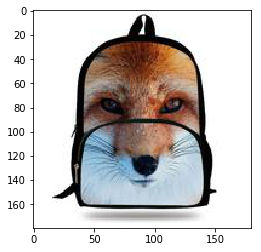

In [36]:
plt.imshow(bx[-1].astype(np.uint8))

In [37]:
cat_idx = np.argmax(by[-1])
cat_id = idx2cat[cat_idx]
categories_df.loc[cat_id]

category_level1       BAGAGERIE
category_level2    MAROQUINERIE
category_level3       SAC A DOS
category_idx                933
Name: 1000010055, dtype: object

In [39]:
%time bx, by = next(val_gen)

CPU times: user 160 ms, sys: 16 ms, total: 176 ms
Wall time: 274 ms


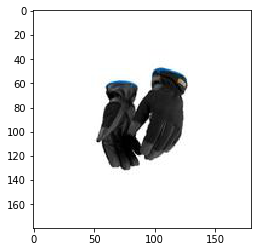

In [40]:
plt.imshow(bx[-1].astype(np.uint8))

In [41]:
cat_idx = np.argmax(by[-1])
cat_id = idx2cat[cat_idx]
categories_df.loc[cat_id]

category_level1            AUTO - MOTO
category_level2              OUTILLAGE
category_level3    GANTS DE PROTECTION
category_idx                       625
Name: 1000005647, dtype: object

### Training

In [42]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D

model = Sequential()
model.add(Conv2D(32, 3, padding="same", activation="relu", input_shape=(180, 180, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPooling2D())
model.add(GlobalAveragePooling2D())
model.add(Dense(num_classes, activation="softmax"))

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 22, 22, 128)       0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 128)               0         
__________

In [43]:
model.fit_generator(train_gen,
                    steps_per_epoch = num_train_images // batch_size,
                    epochs = 1,
                    validation_data = val_gen,
                    validation_steps = num_val_images // batch_size,
                    workers = 8)

Epoch 1/1
 115/7742 [..............................] - ETA: 39802s - loss: 7.3422 - acc: 0.0095

KeyboardInterrupt: 

In [51]:
0.

0.0